# Projet 7 : Home Credit


### Sommaire

### - <a href="#C1">Description de la mission</a>

### - <a href="#C2">Import des librairies et du jeu de données</a>
<br>
&nbsp; - <a href="#C9">Import Librairies</a><br>
<br>
&nbsp; - <a href="#C10">Fonctions</a><br>
<br>
&nbsp; - <a href="#C11">Import du jeu de données</a><br>

### - <a href="#C3">EDA et nettoyage</a>
<br>
&nbsp; - <a href="#C12">Data Drift</a><br>
<br>
&nbsp; - <a href="#C13">EDA</a><br>
<br>
&nbsp; - <a href="#C14">Pre-processing</a><br>

### - <a href="#C5">Entrainement du modéle</a> <br>
<br>
&nbsp; - <a href="#C26">Dummy</a><br>
<br>
&nbsp; - <a href="#C25">LightGMB</a><br>
<br>
&nbsp; - <a href="#C28">XGBoost</a><br>
<br>
&nbsp; - <a href="#C29">AdaBoost</a><br>
<br>
&nbsp; - <a href="#C24">Régression Logistique</a><br>


### - <a href="#C6">Méthodes de sampling</a><br>
<br>
&nbsp; - <a href="#C16">SMOTE</a><br>
<br>
&nbsp; - <a href="#C17">UnderSampling</a><br>
<br>
&nbsp; - <a href="#C18">OverSampling</a><br>

### - <a href="#C30">Dernière Pipeline</a><br>
<br>
&nbsp; - <a href="#C18">Entrainement Pipeline</a><br>
<br>
&nbsp; - <a href="#C27">Shap</a><br>

### - <a href="#C7">Optimisation du threshold</a><br>
<br>
&nbsp; - <a href="#C23">Optimisation du threshold</a>
<br>

### - <a href="#C31">Tableaux de résultat</a><br>

## <a name="C1">Description de la mission</a>

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

Logo entreprise 
 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## <a name="C2">Import des librairies et du jeu de données</a>

### <a name="C9">Import Librairies</a><br>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import Counter
from time import time
import mlflow
import joblib
from mlflow.models.signature import infer_signature

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# ----------------------------------------------------
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_validate,cross_val_predict
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score,auc, roc_curve, roc_auc_score,make_scorer

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

#-----------------------------------------------------
import lime
import shap
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# ----------------------------------------------------
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")


### <a name="C10">Fonctions</a><br>

In [8]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    
# ----------------------------------------------------------
def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cost_score(y_true,y_pred,fn_cost=10, fp_cost=1):
    fn = np.sum((y_true == 1) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    loss = fn * fn_cost + fp * fp_cost
    score = -loss
    return score

# ----------------------------------------------------------
def opti_threshold(y_true, y_prob, fn_cost=10, fp_cost=1,step=0.0001):

    cost_min = np.inf
    opti_thresh = 0.0
    for threshold in np.arange(0.0, 1.0, step):
        y_pred = (y_prob >= threshold).astype(int)
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * fn_cost + fp * fp_cost
        if cost < cost_min:
          cost_min = cost
          opti_thresh = threshold
        
        
    return cost_min,opti_thresh

scorer  = make_scorer(cost_score, greater_is_better=True)
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    clf = RandomizedSearchCV(model, params, scoring =scorer, cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

# ----------------------------------------------------------
def model_scoring(X,y,model,threshold=0.5,print_=False,plot_matrix = False,plot_auc= False):
    start = time()
    y_pred_proba = cross_val_predict(model,X,y,cv=kfold,method='predict_proba')[:, 1]
    end = time()
    tot = (end - start)/5
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy=accuracy_score(y, y_pred)
    recall=recall_score(y,y_pred)
    precision=precision_score(y,y_pred)
    rocauc=roc_auc_score(y,y_pred_proba)
    score = cost_score(y,y_pred)
    if plot_matrix:
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
    if print_:
        print('{:.4f}'.format(tot), '- Time')
        print('{:.4f}'.format(accuracy), '- Accuracy')
        print('{:.4f}'.format(recall), '- Recall')
        print('{:.4f}'.format(precision), '- Precision')
        print('{:.4f}'.format(rocauc), '- ROC AUC')
        print('{:.4f}'.format(score), '- Score')
    fig = None
    if plot_auc:
        fpr, tpr, threshold = roc_curve(y, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        fig = plt.figure()
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
    return tot,accuracy,recall,precision,rocauc,score,fig

# ----------------------------------------------------------
def run_mlflow_experiment(X,y,model,model_name,exp_name,fig_name,hyperparams,threshold=0.5):
    tot,accuracy,recall,precision,rocauc,score,fig = model_scoring(X,y,model,threshold,plot_auc=True)
    plt.savefig(fig_name)
    # Nom de l'expérience
    experiment_name = exp_name
    
    # Initialisation de l'expérience
    mlflow.set_experiment(experiment_name)
    
    # Démarrage d'un run
    with mlflow.start_run():
        
        # Enregistrement des hyperparamètres
        mlflow.log_params(hyperparams)
        
        # Enregistrement des métriques
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("score_metier", score)
        mlflow.log_metric("auc_score", rocauc)
        
        # Enregistrement du temps de traitement de fit et de prédiction
        mlflow.log_metric("fit_time", tot)
        
        # Enregistrement des graphiques
        mlflow.log_figure(fig,artifact_file = fig_name)
        
        # Enregistrement du modèle entraîné
        mlflow.sklearn.log_model(model, model_name)


### <a name="C11">Import du jeu de données</a><br>

In [9]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")

## <a name="C3">EDA et nettoyage</a>

### <a name="C12">Data Drift</a><br>

In [10]:
#report = Report(metrics=[
#    DataDriftPreset(), 
#])

#report.run(reference_data=train.drop(columns='TARGET'), current_data=test)
#report

In [11]:
#report.save_html('report.html')

### <a name="C13">EDA</a><br>

In [12]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


0    282686
1     24825
Name: TARGET, dtype: int64

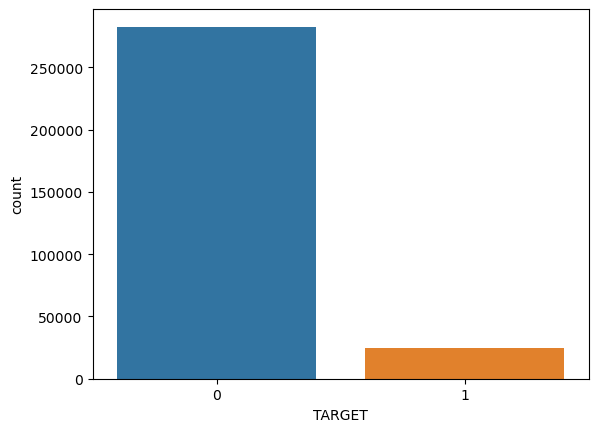

In [15]:
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

In [16]:
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
*******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [17]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [18]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MEDI,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_MODE,210199
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199


In [19]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
NONLIVINGAPARTMENTS_MEDI,33347
FONDKAPREMONT_MODE,32797
LIVINGAPARTMENTS_AVG,32780
LIVINGAPARTMENTS_MODE,32780
LIVINGAPARTMENTS_MEDI,32780


### <a name="C14">Pre-processing</a><br>

In [20]:
threshold_train = len(train) * 0.60
int(threshold_train)

184506

In [21]:
threshold_test = len(test) * 0.60
int(threshold_test)

29246

In [22]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [23]:
train_new = train.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(307511, 73)
******************************************
(48744, 72)


In [24]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [25]:
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]
numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   CNT_CHILDREN                 307511 non-null  int64  
 3   AMT_INCOME_TOTAL             307511 non-null  float64
 4   AMT_CREDIT                   307511 non-null  float64
 5   AMT_ANNUITY                  307499 non-null  float64
 6   AMT_GOODS_PRICE              307233 non-null  float64
 7   REGION_POPULATION_RELATIVE   307511 non-null  float64
 8   DAYS_BIRTH                   307511 non-null  int64  
 9   DAYS_EMPLOYED                307511 non-null  int64  
 10  DAYS_REGISTRATION            307511 non-null  float64
 11  DAYS_ID_PUBLISH              307511 non-null  int64  
 12  FLAG_MOBIL                   307511 non-null  int64  
 13 

In [26]:
numeric_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   48744 non-null  int64  
 1   CNT_CHILDREN                 48744 non-null  int64  
 2   AMT_INCOME_TOTAL             48744 non-null  float64
 3   AMT_CREDIT                   48744 non-null  float64
 4   AMT_ANNUITY                  48720 non-null  float64
 5   AMT_GOODS_PRICE              48744 non-null  float64
 6   REGION_POPULATION_RELATIVE   48744 non-null  float64
 7   DAYS_BIRTH                   48744 non-null  int64  
 8   DAYS_EMPLOYED                48744 non-null  int64  
 9   DAYS_REGISTRATION            48744 non-null  float64
 10  DAYS_ID_PUBLISH              48744 non-null  int64  
 11  FLAG_MOBIL                   48744 non-null  int64  
 12  FLAG_EMP_PHONE               48744 non-null  int64  
 13  FLAG_WORK_PHONE 

In [27]:
discrete_features = numeric.dtypes==int
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes==int
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
discrete_test.head()

,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,0,-19241,-2329,-812,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,100005,0,-18064,-4469,-1623,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,-20038,-4458,-3503,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,100028,2,-13976,-1866,-4208,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,-13040,-2191,-4262,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
FLAG_DOCUMENT_2,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [30]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
CNT_CHILDREN,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [31]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_test = numeric_test[final_continuous_feature]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,1.0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,2.0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,1.0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,2.0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,1.0,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            307511 non-null  float64
 1   AMT_CREDIT                  307511 non-null  float64
 2   AMT_ANNUITY                 307499 non-null  float64
 3   AMT_GOODS_PRICE             307233 non-null  float64
 4   REGION_POPULATION_RELATIVE  307511 non-null  float64
 5   DAYS_REGISTRATION           307511 non-null  float64
 6   CNT_FAM_MEMBERS             307509 non-null  float64
 7   EXT_SOURCE_2                306851 non-null  float64
 8   EXT_SOURCE_3                246546 non-null  float64
 9   OBS_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 10  DEF_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 11  OBS_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 13  DAYS_LAST_PHON

In [33]:
continuous_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AMT_INCOME_TOTAL            48744 non-null  float64
 1   AMT_CREDIT                  48744 non-null  float64
 2   AMT_ANNUITY                 48720 non-null  float64
 3   AMT_GOODS_PRICE             48744 non-null  float64
 4   REGION_POPULATION_RELATIVE  48744 non-null  float64
 5   DAYS_REGISTRATION           48744 non-null  float64
 6   CNT_FAM_MEMBERS             48744 non-null  float64
 7   EXT_SOURCE_2                48736 non-null  float64
 8   EXT_SOURCE_3                40076 non-null  float64
 9   OBS_30_CNT_SOCIAL_CIRCLE    48715 non-null  float64
 10  DEF_30_CNT_SOCIAL_CIRCLE    48715 non-null  float64
 11  OBS_60_CNT_SOCIAL_CIRCLE    48715 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE    48715 non-null  float64
 13  DAYS_LAST_PHONE_CHANGE      487

In [34]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,60965
AMT_REQ_CREDIT_BUREAU_YEAR,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_HOUR,41519
OBS_60_CNT_SOCIAL_CIRCLE,1021
DEF_60_CNT_SOCIAL_CIRCLE,1021
DEF_30_CNT_SOCIAL_CIRCLE,1021


In [35]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,8668
AMT_REQ_CREDIT_BUREAU_YEAR,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_HOUR,6049
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
DEF_30_CNT_SOCIAL_CIRCLE,29


In [36]:
continuous_col = continuous.columns

In [37]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

*********************** AMT_INCOME_TOTAL ***********************

lower outlier: 0 ****** upper outlier: 14035



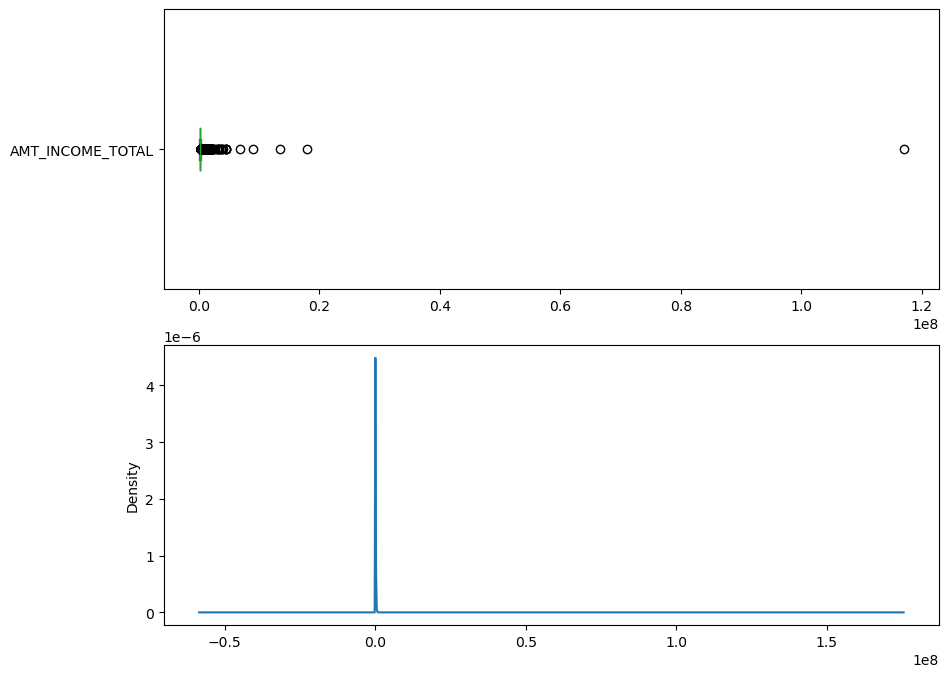

*********************** AMT_CREDIT ***********************

lower outlier: 0 ****** upper outlier: 6562



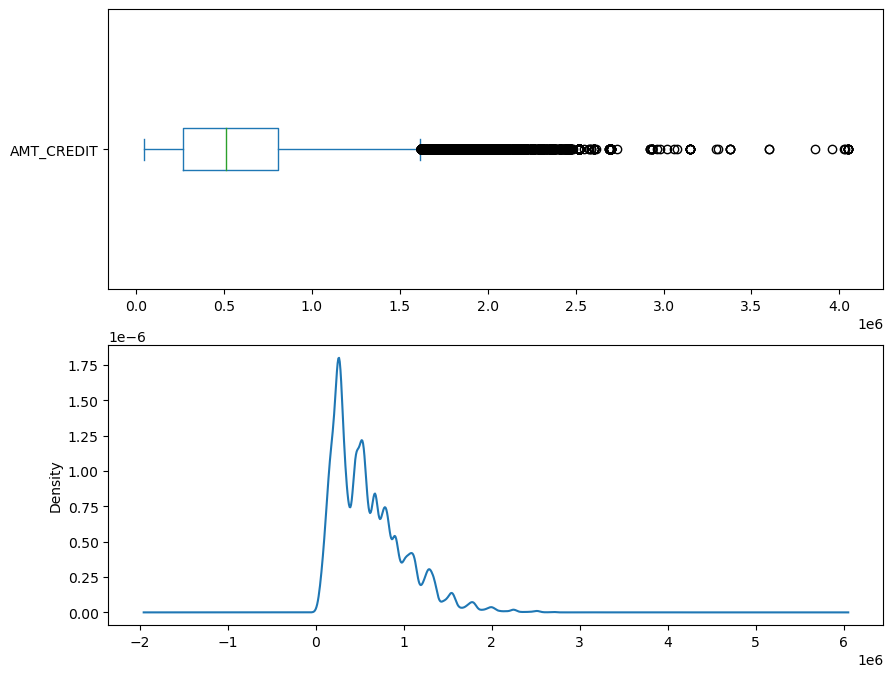

*********************** AMT_ANNUITY ***********************

lower outlier: 0 ****** upper outlier: 7504



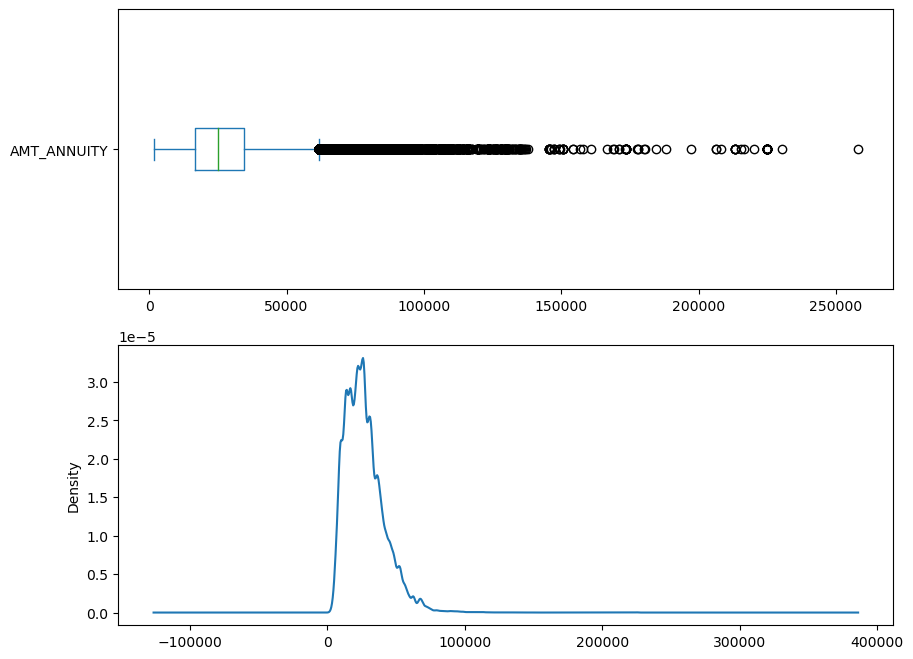

*********************** AMT_GOODS_PRICE ***********************

lower outlier: 0 ****** upper outlier: 14728



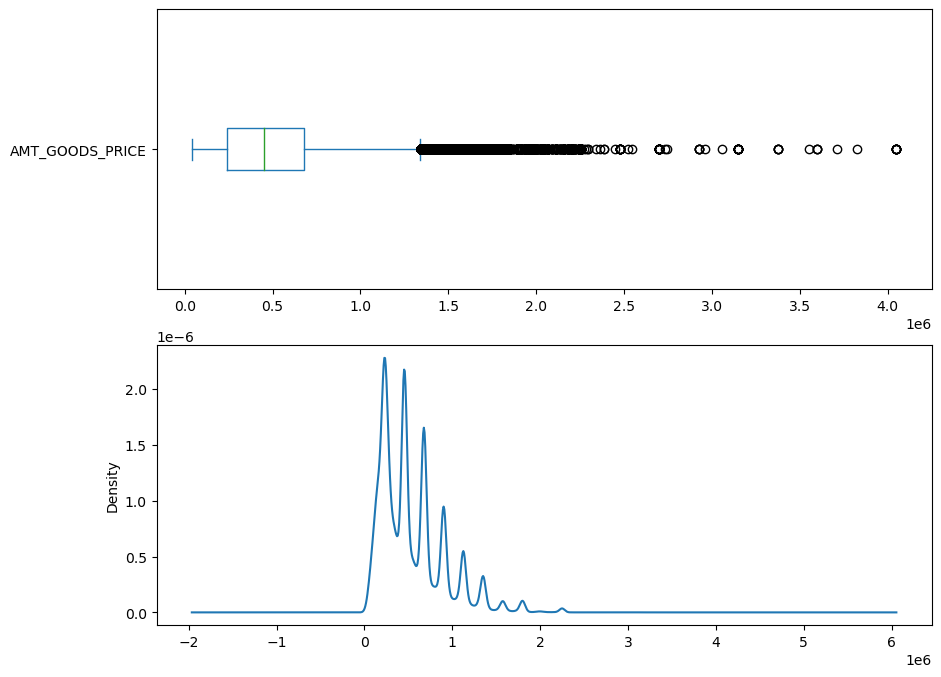

*********************** REGION_POPULATION_RELATIVE ***********************

lower outlier: 0 ****** upper outlier: 8412



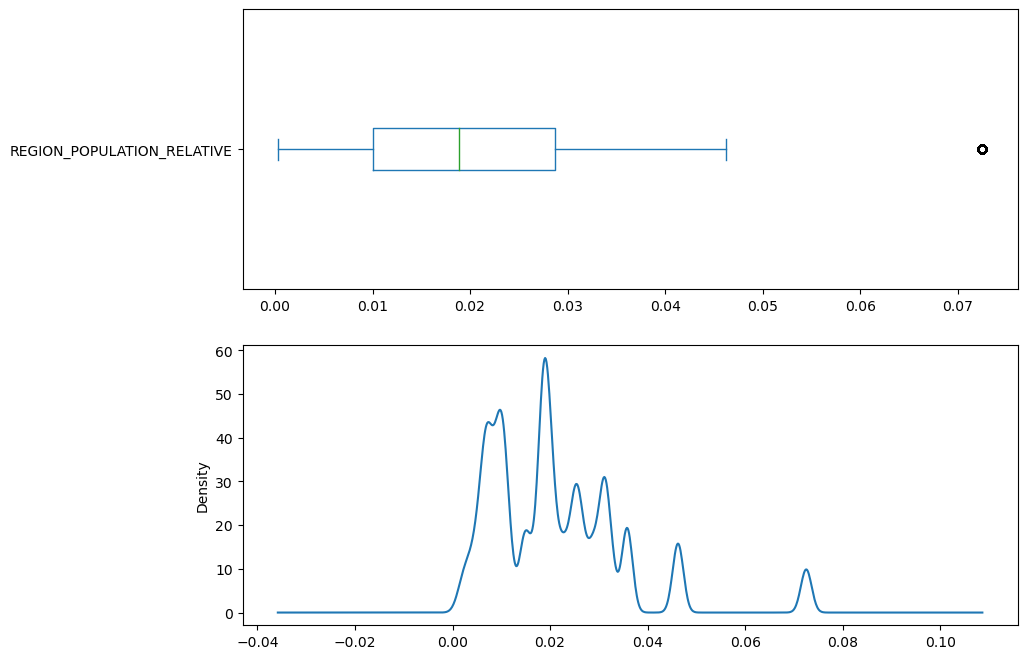

*********************** DAYS_REGISTRATION ***********************

lower outlier: 659 ****** upper outlier: 0



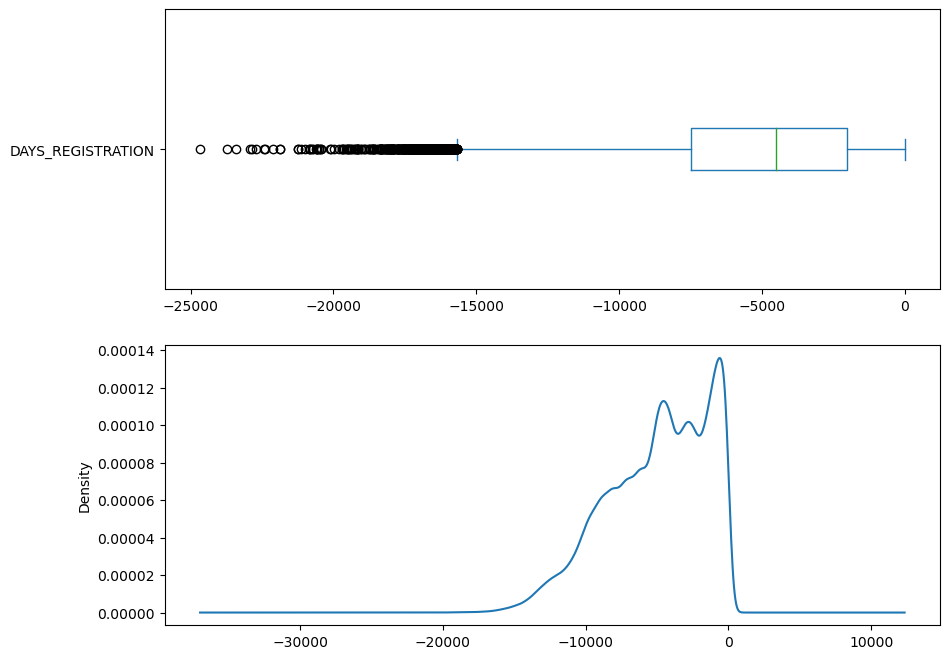

*********************** CNT_FAM_MEMBERS ***********************

lower outlier: 0 ****** upper outlier: 4007



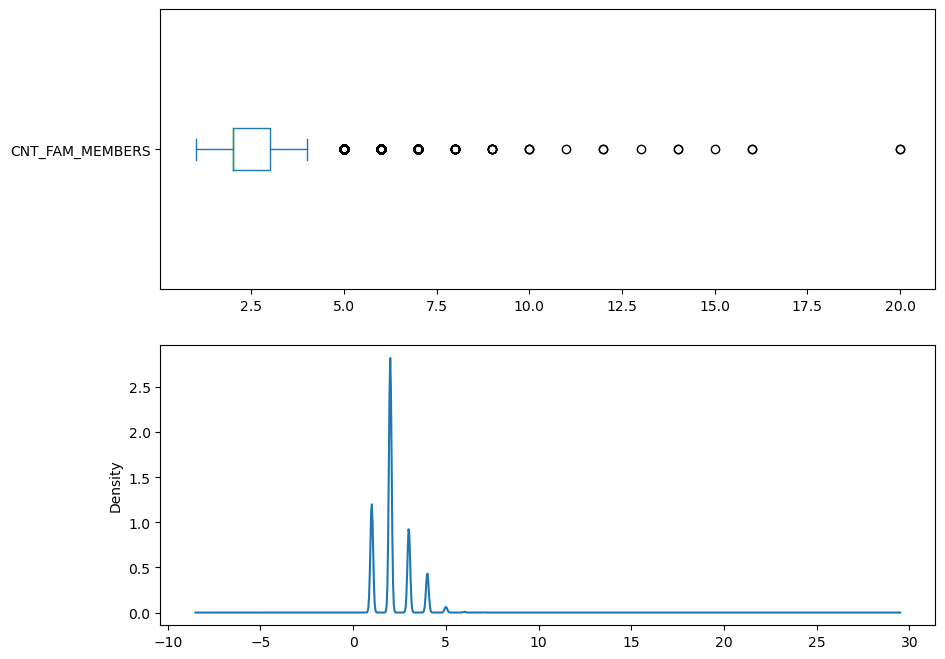

*********************** EXT_SOURCE_2 ***********************

lower outlier: 0 ****** upper outlier: 0



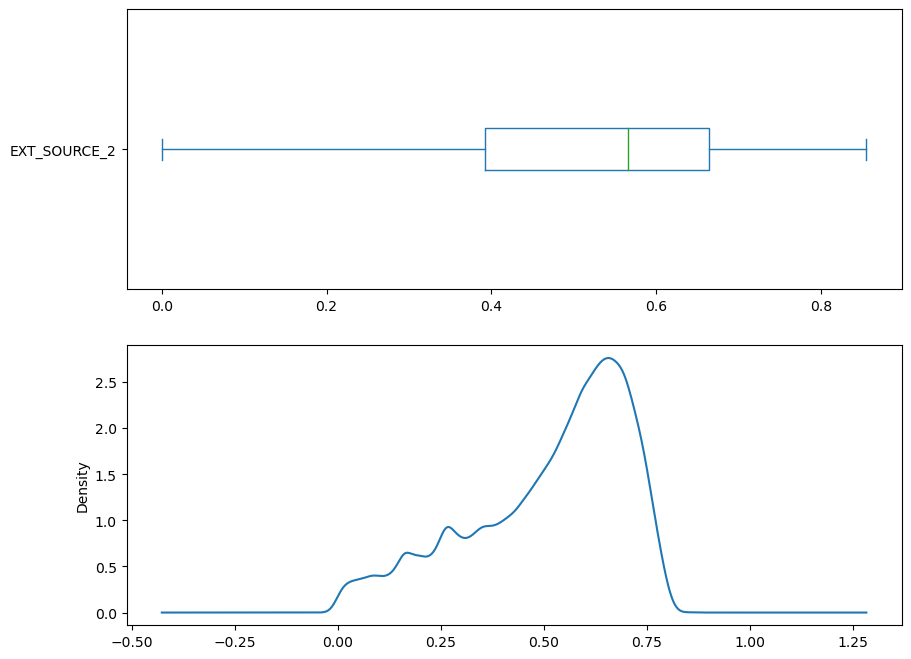

*********************** EXT_SOURCE_3 ***********************

lower outlier: 0 ****** upper outlier: 0



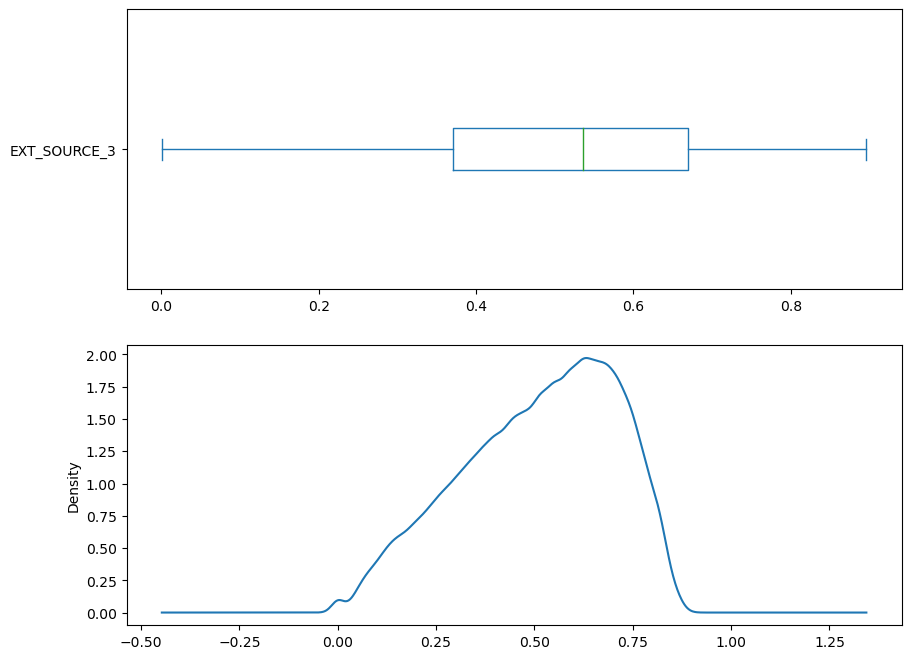

*********************** OBS_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19971



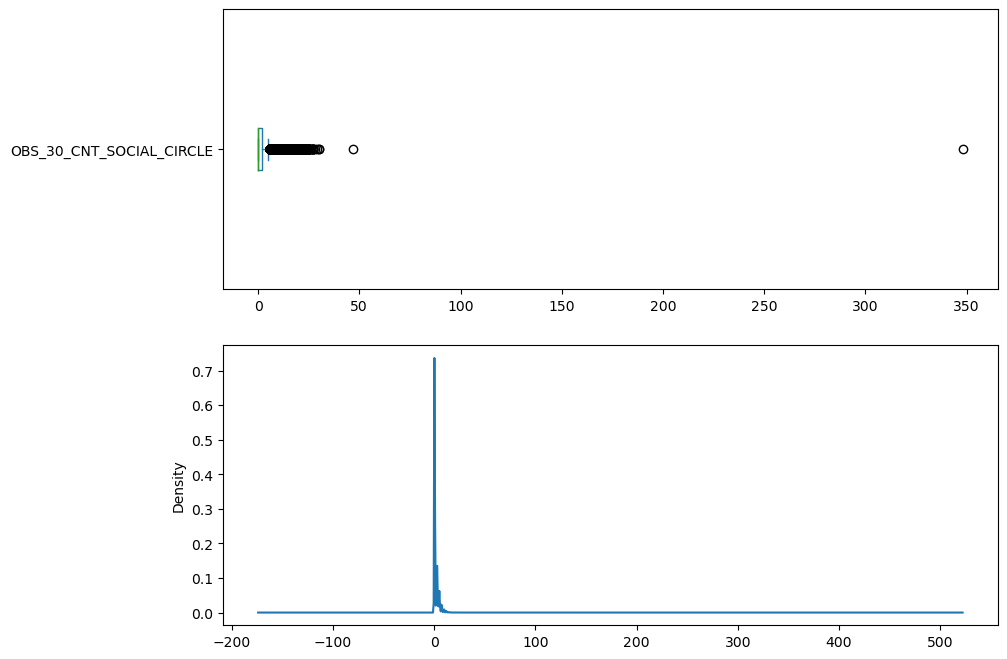

*********************** DEF_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 35166



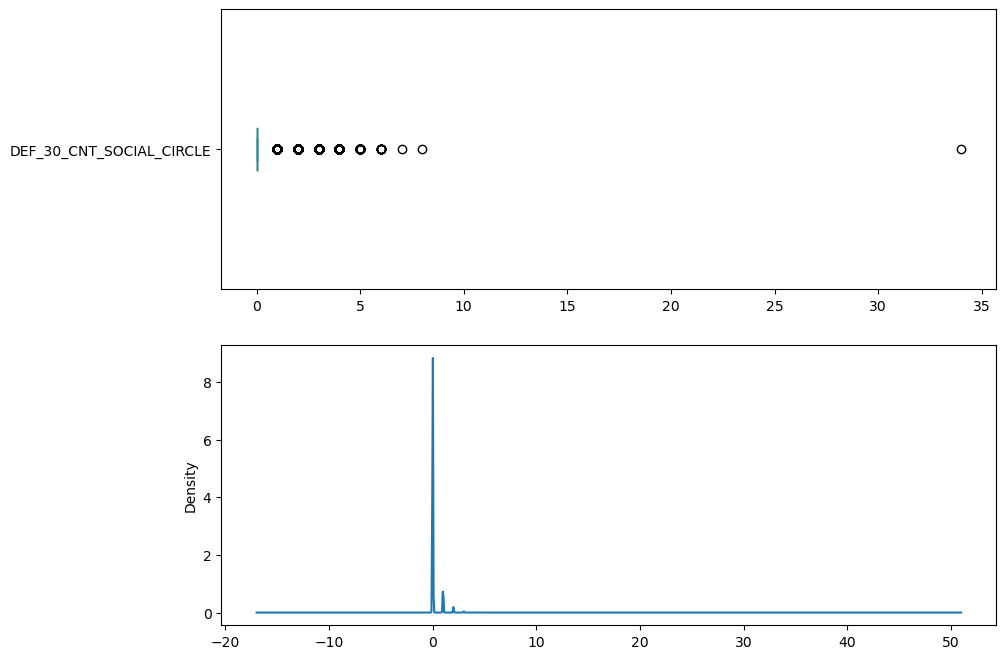

*********************** OBS_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19564



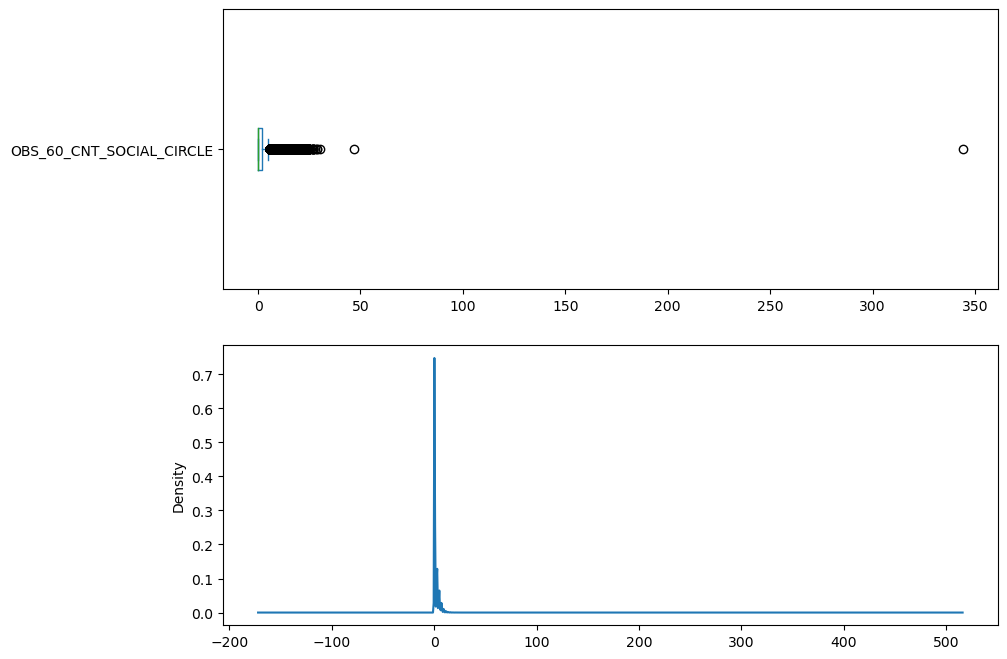

*********************** DEF_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 25769



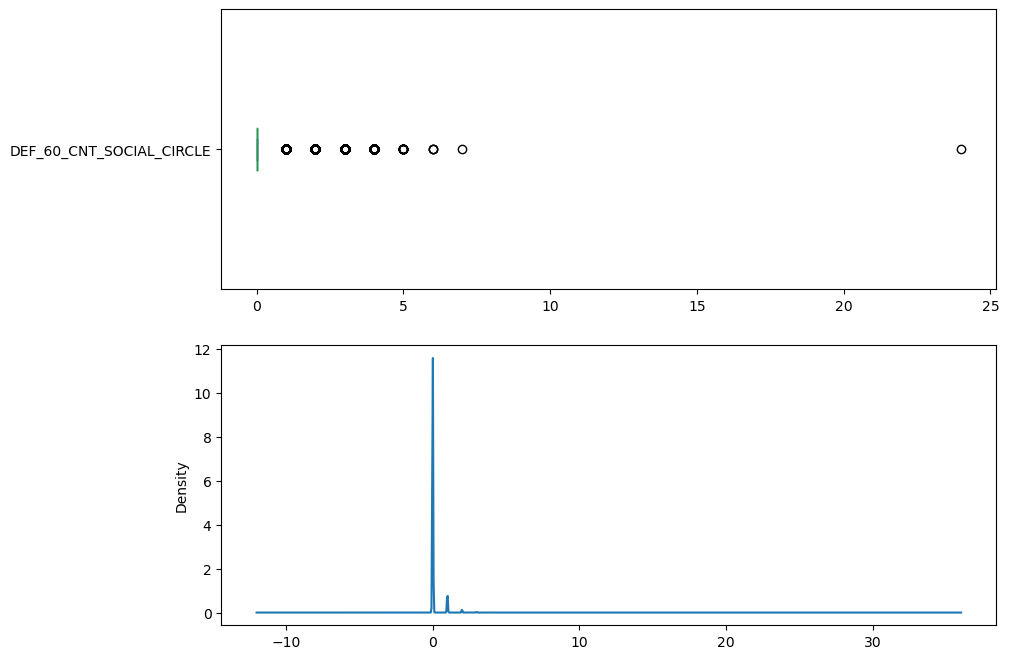

*********************** DAYS_LAST_PHONE_CHANGE ***********************

lower outlier: 435 ****** upper outlier: 0



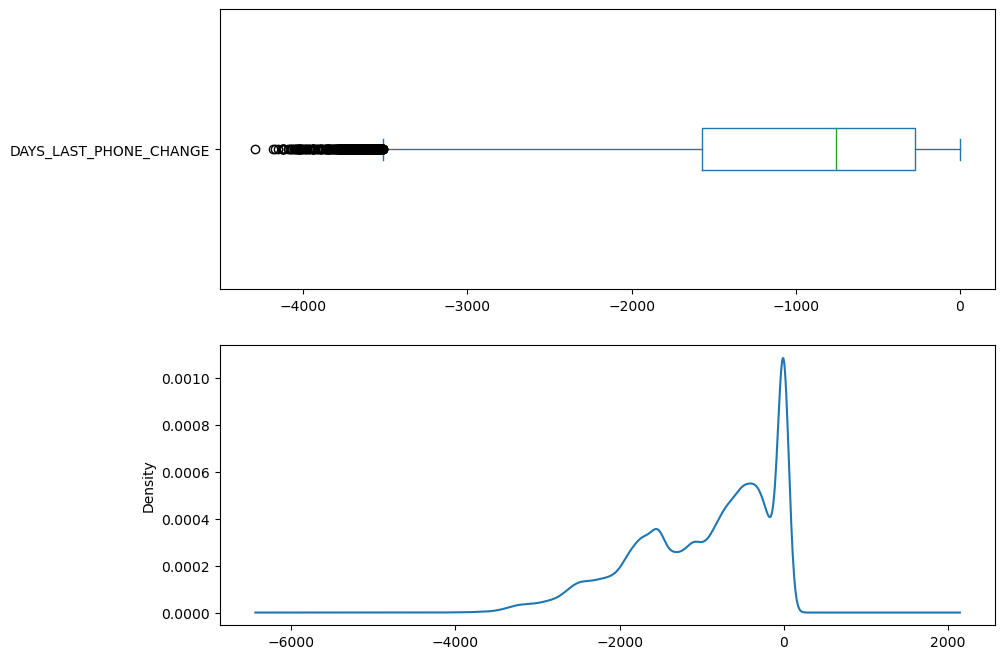

*********************** AMT_REQ_CREDIT_BUREAU_HOUR ***********************

lower outlier: 0 ****** upper outlier: 1626



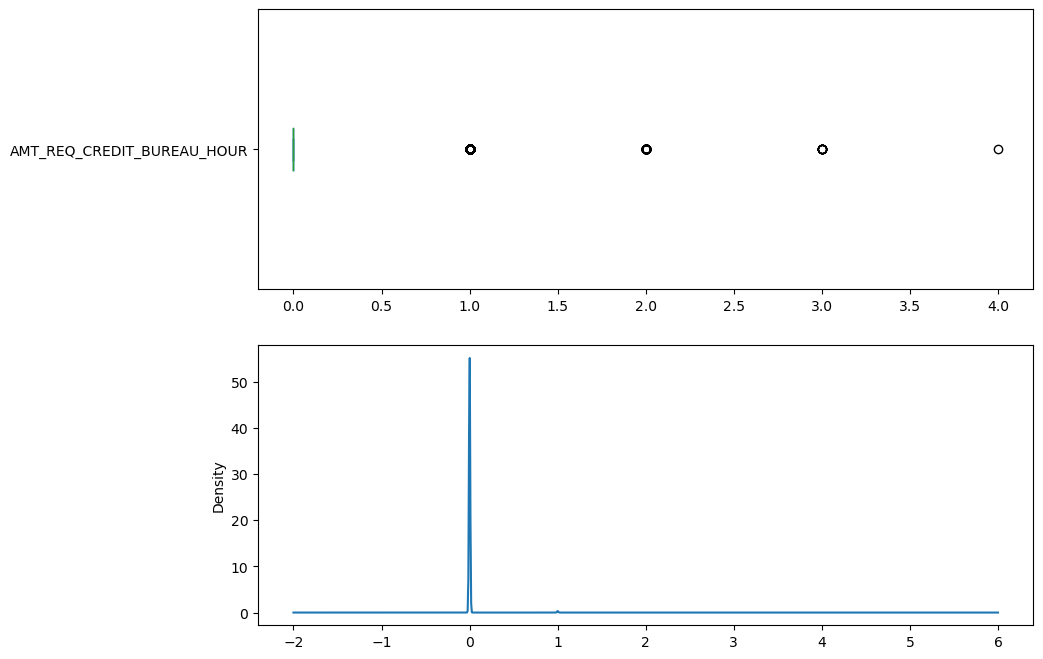

*********************** AMT_REQ_CREDIT_BUREAU_DAY ***********************

lower outlier: 0 ****** upper outlier: 1489



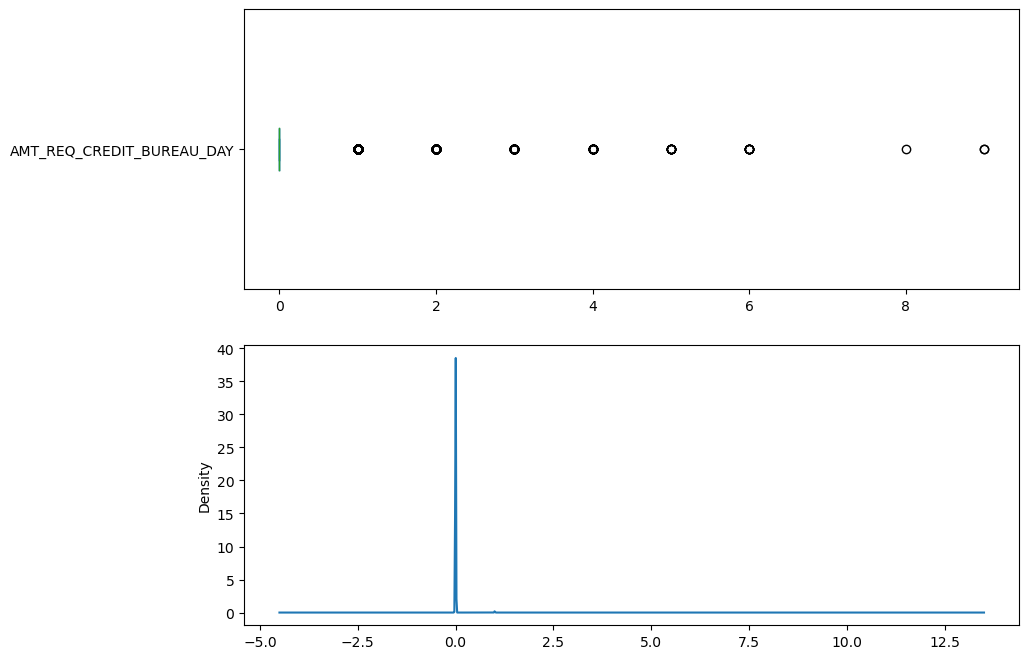

*********************** AMT_REQ_CREDIT_BUREAU_WEEK ***********************

lower outlier: 0 ****** upper outlier: 8536



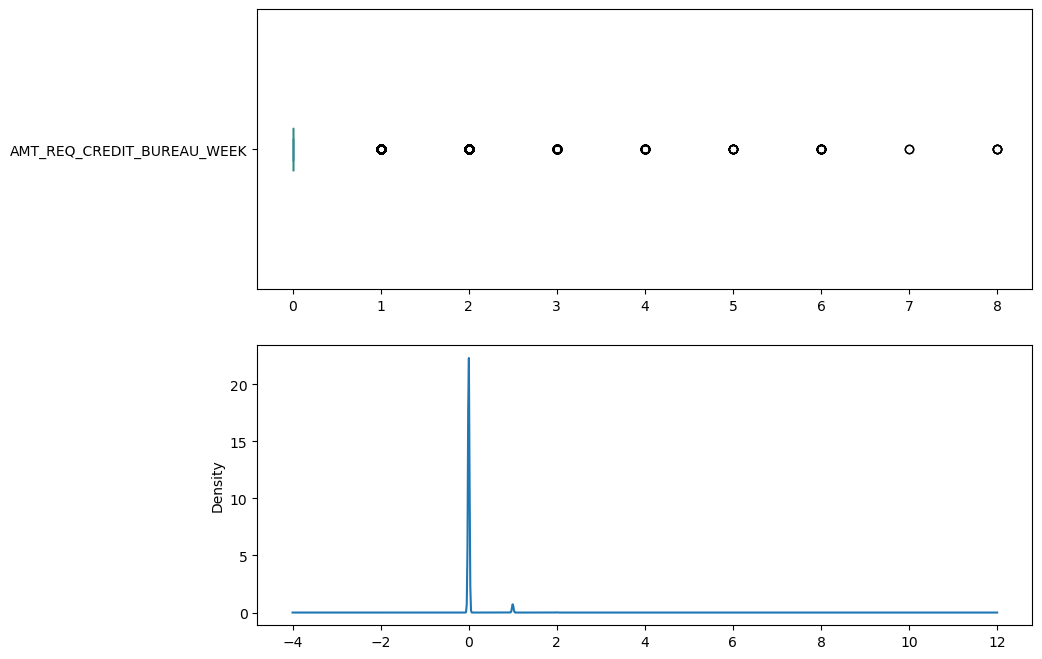

*********************** AMT_REQ_CREDIT_BUREAU_MON ***********************

lower outlier: 0 ****** upper outlier: 43759



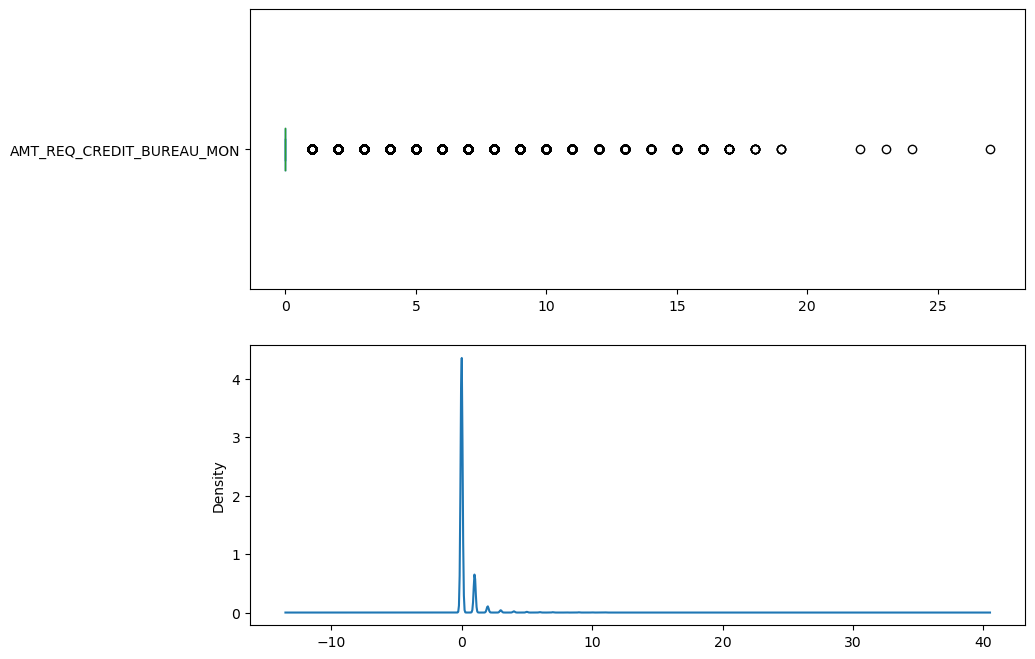

*********************** AMT_REQ_CREDIT_BUREAU_QRT ***********************

lower outlier: 0 ****** upper outlier: 50575



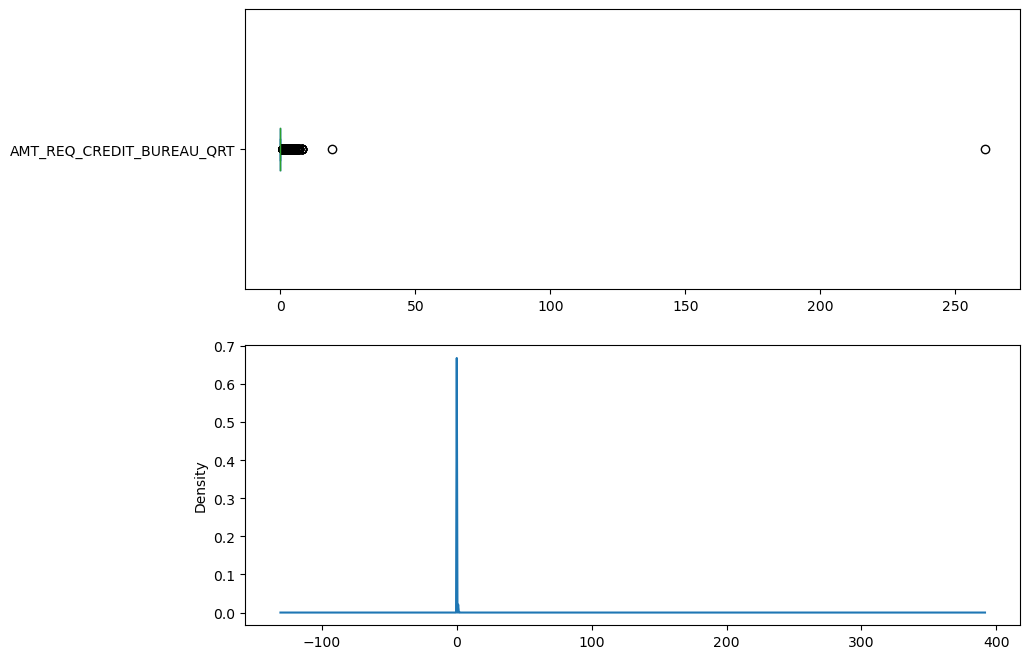

*********************** AMT_REQ_CREDIT_BUREAU_YEAR ***********************

lower outlier: 0 ****** upper outlier: 3364



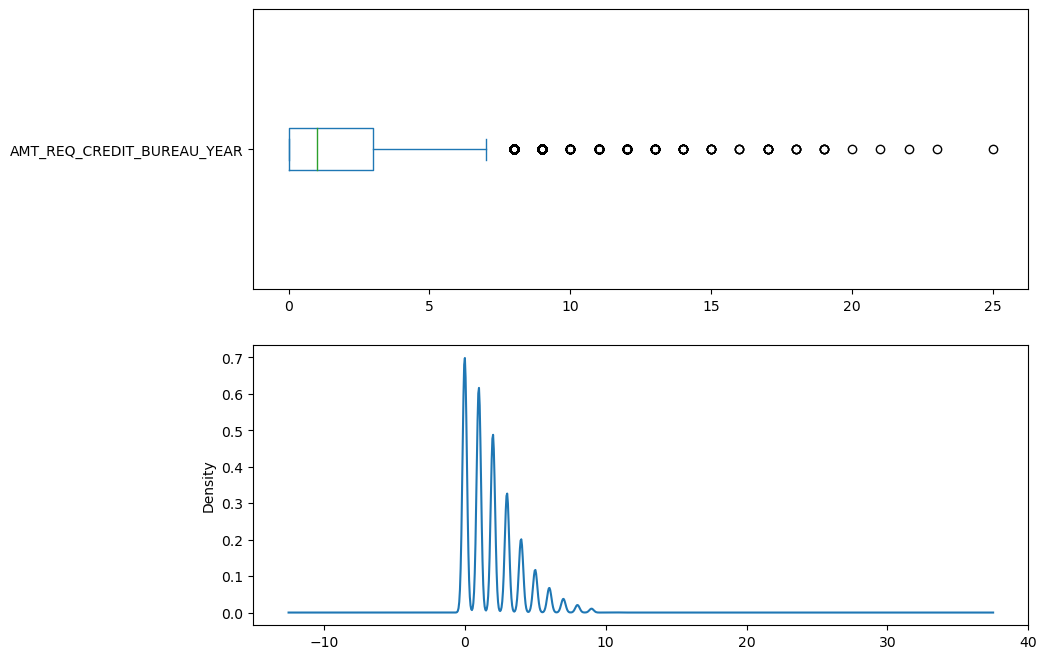

In [38]:
for i in range(len(continuous_col)):
    preprocess(continuous[continuous_col], continuous_col[i])

In [39]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [40]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27108.573909183444
NaN in AMT_GOODS_PRICE raplaced with 538396.2074288892
NaN in CNT_FAM_MEMBERS raplaced with 2.1526654504421012
NaN in EXT_SOURCE_2 raplaced with 0.5143926741308464
NaN in EXT_SOURCE_3 raplaced with 0.5108529061799658
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4222454239942577
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.14342066625338512
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4052921791901856
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10004894123788702
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.8587883320869
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.006402448193930642
NaN in AMT_REQ_CREDIT_BUREAU_DAY raplaced with 0.0070002105326475985
NaN in AMT_REQ_CREDIT_BUREAU_WEEK raplaced with 0.03436193569731421
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26739526000781977
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.2654741495984842
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.899974

In [41]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [42]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [43]:
continuous_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AMT_INCOME_TOTAL            48744 non-null  float64
 1   AMT_CREDIT                  48744 non-null  float64
 2   AMT_ANNUITY                 48744 non-null  float64
 3   AMT_GOODS_PRICE             48744 non-null  float64
 4   REGION_POPULATION_RELATIVE  48744 non-null  float64
 5   DAYS_REGISTRATION           48744 non-null  float64
 6   CNT_FAM_MEMBERS             48744 non-null  float64
 7   EXT_SOURCE_2                48744 non-null  float64
 8   EXT_SOURCE_3                48744 non-null  float64
 9   OBS_30_CNT_SOCIAL_CIRCLE    48744 non-null  float64
 10  DEF_30_CNT_SOCIAL_CIRCLE    48744 non-null  float64
 11  OBS_60_CNT_SOCIAL_CIRCLE    48744 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE    48744 non-null  float64
 13  DAYS_LAST_PHONE_CHANGE      487

In [44]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

In [45]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [46]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In train:

SK_ID_CURR: 0
TARGET: 24825
CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_BIRTH: 0
DAYS_EMPLOYED: 72217
DAYS_REGISTRATION: 659
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 574
FLAG_PHONE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 80527
REGION_RATING_CLIENT_W_CITY: 78027
HOUR_APPR_PROCESS_START: 2257
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 

In [47]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [48]:
# without TARGET field
col_names = outlier_test

In [49]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_EMPLOYED: 55374
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 48330
REGION_RATING_CLIENT_W_CITY: 43860
HOUR_APPR_PROCESS_START: 596
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_DOCUMENT_9: 1198
FLAG_DOCUMENT_11: 1203
FLAG_DOCUMENT_18: 2500
AMT_REQ_CREDIT_BUREAU_HOUR: 43145
AMT_REQ_CREDIT_BUREAU_DAY: 43008
AMT_REQ_CREDIT_B

In [50]:
for i in range(len(col_names)):
    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i])   

In [51]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

In [52]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 16843
DAYS_REGISTRATION: 659
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 574
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 32197
REGION_RATING_CLIENT_W_CITY: 34167
HOUR_APPR_PROCESS_START: 1661
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BU

In [53]:
for i in range(len(col_names)):
    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])

In [54]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

In [55]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [56]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [57]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,96391
NAME_TYPE_SUITE,1292
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [58]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,15605
NAME_TYPE_SUITE,911
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [59]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



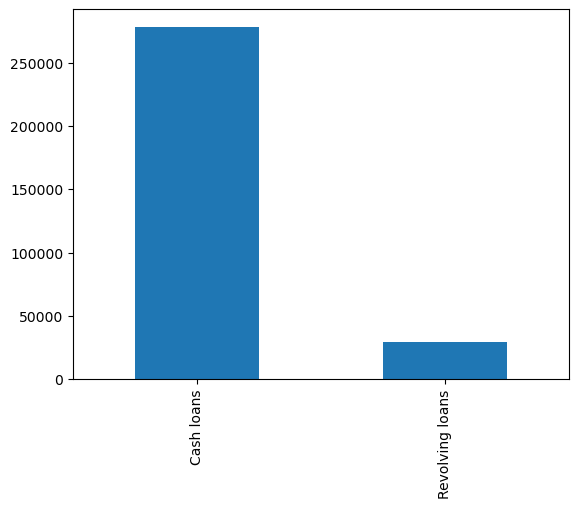

******************** CODE_GENDER ********************



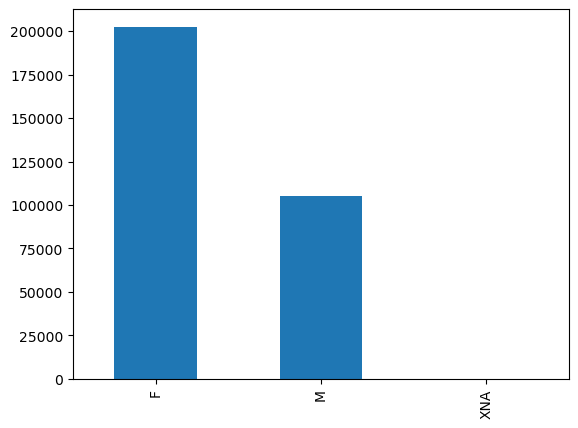

******************** FLAG_OWN_CAR ********************



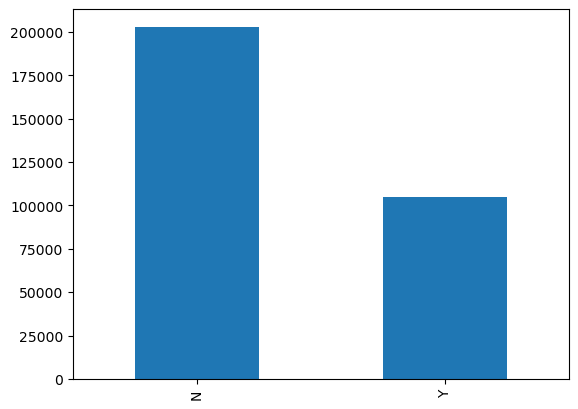

******************** FLAG_OWN_REALTY ********************



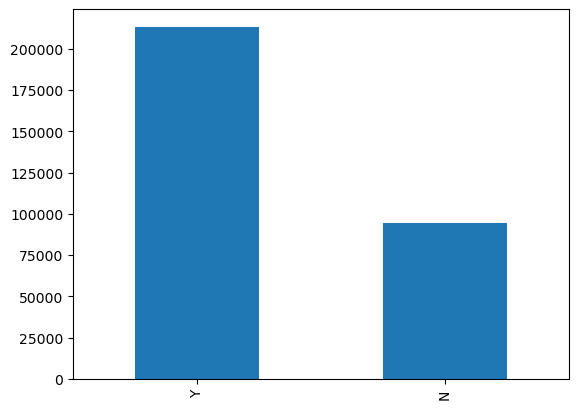

******************** NAME_TYPE_SUITE ********************



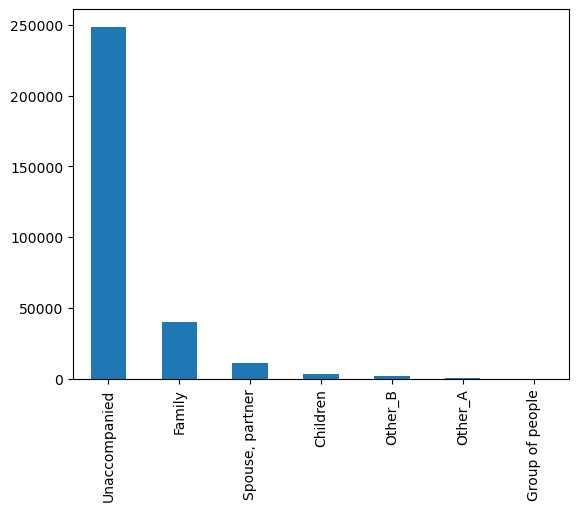

******************** NAME_INCOME_TYPE ********************



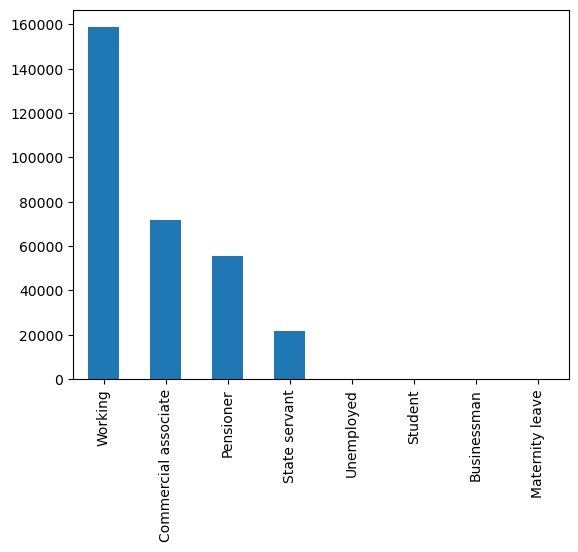

******************** NAME_EDUCATION_TYPE ********************



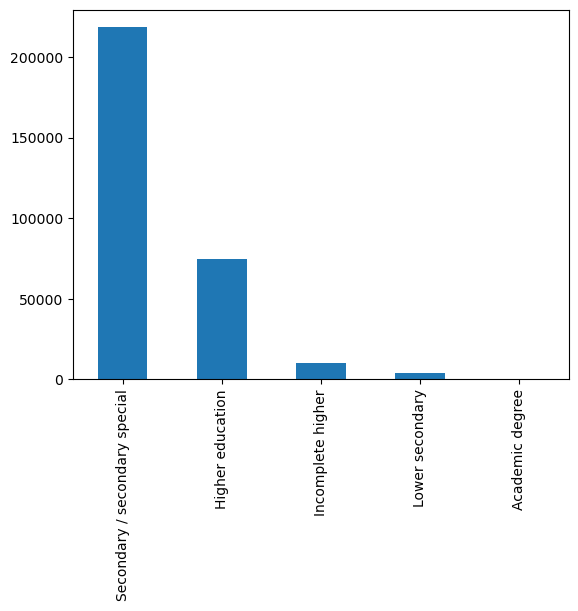

******************** NAME_FAMILY_STATUS ********************



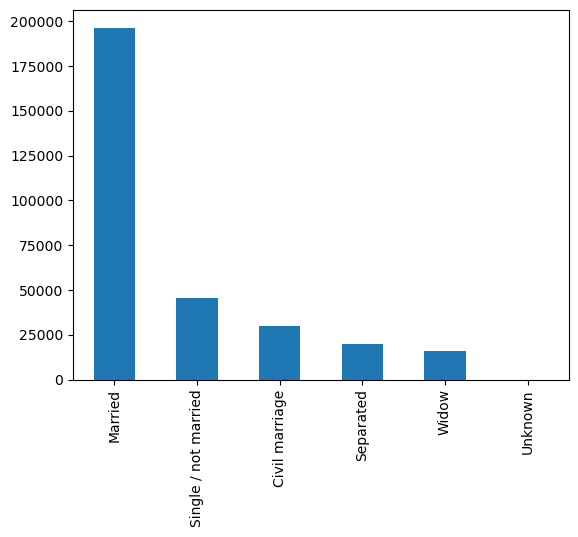

******************** NAME_HOUSING_TYPE ********************



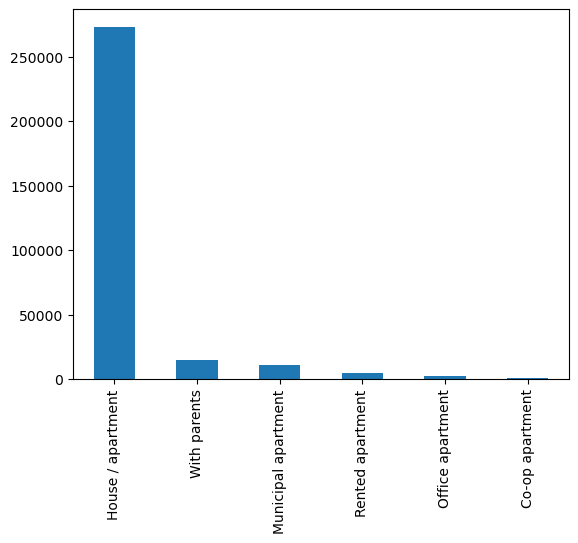

******************** OCCUPATION_TYPE ********************



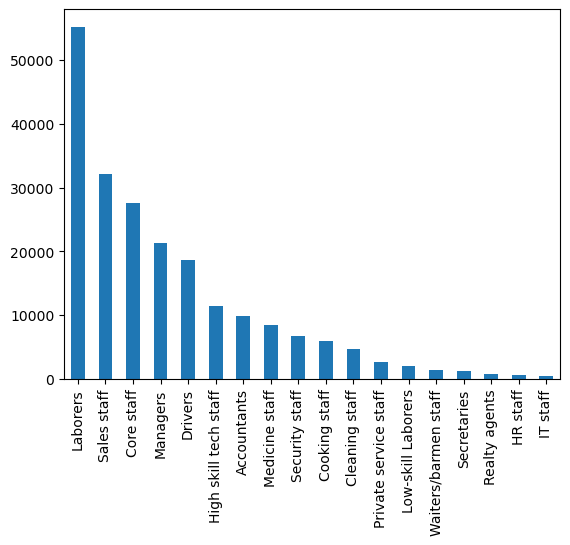

******************** WEEKDAY_APPR_PROCESS_START ********************



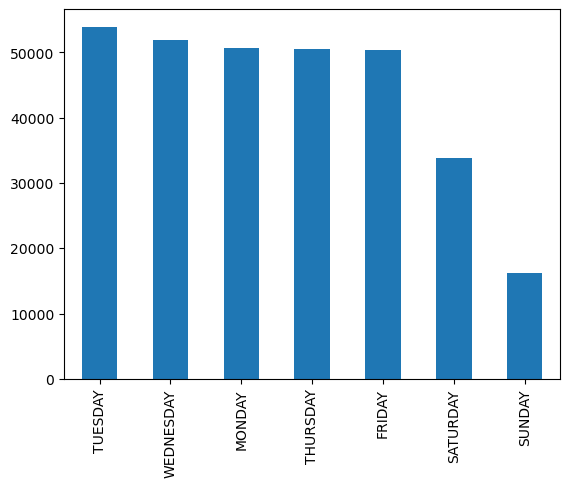

******************** ORGANIZATION_TYPE ********************



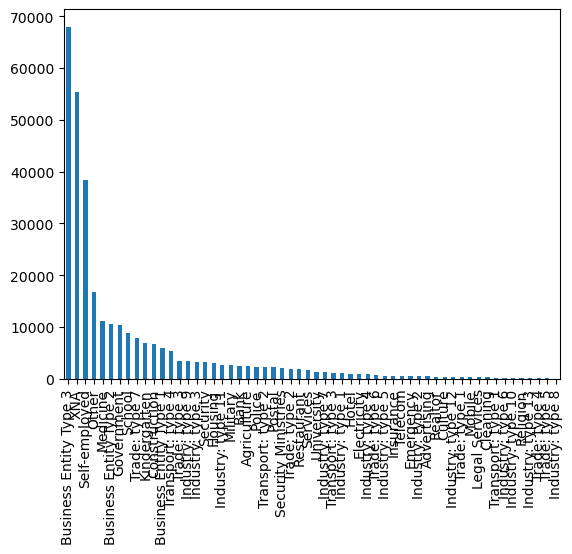

In [60]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [61]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6'] 


In [62]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in WEEKDAY_APPR_PROCESS_START raplaced with TUESDAY
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in N

In [63]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [64]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [65]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [66]:
le = LabelEncoder() 
categorical_enc = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test_enc = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_enc.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START
0,0,1,0,1,6,7,4,3,1,8,6
1,0,0,0,0,1,4,1,1,1,3,1
2,1,1,1,1,6,7,4,3,1,8,1
3,0,0,0,1,6,7,4,0,1,8,6
4,0,1,0,1,6,7,4,3,1,3,4


In [67]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (307511, 11)
In test:  (48744, 11)


In [68]:
col_names_cat = categorical.columns
col_names = numeric_test.columns

In [69]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [70]:
train_new_enc = pd.DataFrame()
test_new_enc = pd.DataFrame()


In [71]:
train_new_enc[col_names_cat] = categorical_enc[col_names_cat]
train_new_enc[col_names] = numeric[col_names]
train_new_enc['TARGET'] = train_new['TARGET']

# ----------------------------------------------------
test_new_enc[col_names] = numeric_test[col_names]
test_new_enc[col_names_cat] = categorical_test_enc[col_names_cat]

In [72]:
train_new_enc.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,0,1,0,1,6,7,4,3,1,8,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1
1,0,0,0,0,1,4,1,1,1,3,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2,1,1,1,1,6,7,4,3,1,8,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0,0,0,1,6,7,4,0,1,8,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.899974,0
4,0,1,0,1,6,7,4,3,1,3,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0


In [73]:
train_new.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [75]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 72)
In test:  (0, 71)


In [76]:
train_new.replace('Unknown', np.nan,inplace=True)
train_new_enc.replace('Unknown', np.nan,inplace=True)

In [77]:
train_new.dropna(inplace=True)
train_new_enc.dropna(inplace=True)

In [78]:
col_names = col_names[1:]
col_names

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10'

In [79]:
scaler=StandardScaler()
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


## <a name="C5">Entrainement du modéle</a> <br>

In [80]:
X = train_new_enc.drop(columns = 'TARGET')
y = train_new_enc['TARGET']

### <a name="C26">Dummy</a>

In [132]:
dummy_clf = DummyClassifier(strategy="most_frequent")
tot_dum,accuracy_dum,recall_dum,precision_dum,rocauc_dum,score_dum,fig =model_scoring(X,y,dummy_clf,threshold=0.5)

In [82]:
#params = {}
#run_mlflow_experiment(X,y,dummy_clf,'Dummy','Dummy experiment','dummy_auc_curve.png',params,threshold=0.5)

### <a name="#C14">LightGMB</a><br>

In [83]:
# Value of hyperparameters for random search

param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1,class_weight='balanced' ), 
#              X, y, param_lgb)

In [84]:
lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        class_weight='balanced',
                        random_state= 100)

tot_lgb,accuracy_lgb,recall_lgb,precision_lgb,rocauc_lgb,score_lgb,fig = model_scoring(X,y,lgb,threshold=0.5)

In [85]:
params = {'reg_lambda': 0.1, 
          'reg_alpha' : 0.2, 
          'num_leaves' : 70, 
          'n_estimators' : 100, 
          'min_child_samples' : 800, 
          'learning_rate' : 0.1,
          'max_bin' : 500,
          'objective' : 'binary',
          'class_weight' : 'balanced',
          'random_state' : 100}

In [86]:
#run_mlflow_experiment(X,y,lgb,'LightGBM','LightGBM experiment','lgb_auc_curve.png',params,threshold=0.5)

In [87]:
lgb.fit(X,y)

LGBMClassifier(class_weight='balanced', max_bin=500, min_child_samples=800,
               num_leaves=70, objective='binary', random_state=100,
               reg_alpha=0.2, reg_lambda=0.1)

### <a name="C27">Shap</a>

In [88]:
shap.initjs()

shap_explainer = shap.TreeExplainer(lgb)
shap_values = shap_explainer.shap_values(X)

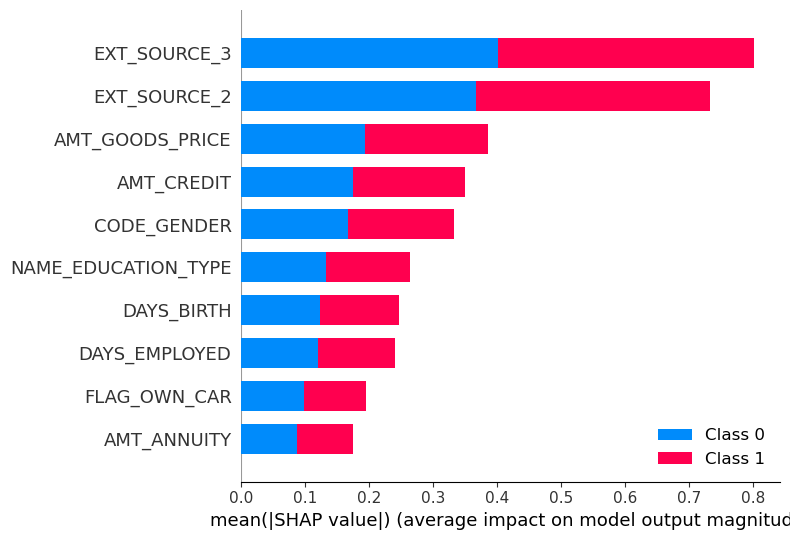

In [89]:
shap.summary_plot(shap_values,features=lgb.feature_name_,max_display=10)

In [90]:
#fig.savefig('Featur_exp.png')

### <a name="C15">XGBoost</a>

In [91]:
# Value of hyperparameters for random search

param_xgbc = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'subsample':[1,0.5,0.2,0.1],
              'max_depth' : range(2,11,1),
              'n_estimators':range(50,300,50)}

#RndSrch_Tune(XGBClassifier(random_state = 100, n_jobs=-1), 
#            X, y, param_xgbc)

In [92]:
xgbc = XGBClassifier(subsample =  0.1,
                    learning_rate=0.1, 
                     max_depth=5,
                     n_estimators =  250, 
                     random_state=100)

tot_xgbc,accuracy_xgbc,recall_xgbc,precision_xgbc,rocauc_xgbc,score_xgbc,fig = model_scoring(X,y,xgbc,threshold=0.5)

In [93]:
params = {'subsample': 0.1, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.1}

#run_mlflow_experiment(X,y,xgbc,'XGBoost','XGBoost experiment','Xgb_auc_curve.png',params)

### <a href="#C29">AdaBoost</a><br>

In [94]:
# Value of hyperparameters for random search

#param_ada = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'algorithm': ['SAMME', 'SAMME.R'],
#              'n_estimators':range(50,300,50)}

#RndSrch_Tune(AdaBoostClassifier(random_state = 100), x_train, y, param_ada)

In [95]:
ada = AdaBoostClassifier(learning_rate=0.2, 
                         algorithm = 'SAMME.R',
                         n_estimators=200, 
                         random_state=100)

tot_ada,accuracy_ada,recall_ada,precision_ada,rocauc_ada,score_ada,fig = model_scoring(X,y,ada,threshold=0.5)


In [96]:
params = {'learning_rate':0.2, 
            'algorithm' : 'SAMME.R',
            'n_estimators':200, 
            'random_state':100}

#run_mlflow_experiment(X,y,ada,'AdaBoost','AdaBoost experiment','Ada_auc_curve.png',params)


### <a name="C15">Régression Logistique</a><br>

In [97]:
logreg=LogisticRegression()
tot_lr,accuracy_lr,recall_lr,precision_lr,rocauc_lr,score_lr,fig = model_scoring(X,y,logreg,threshold=0.5)

In [98]:
params = {}

In [99]:
#run_mlflow_experiment(X,y,logreg,'LogisticRegression','Logreg experiment','Lr_auc_curve.png',params)

## <a name="C6">Méthodes de sampling</a>

In [100]:
### <a name="C16">SMOTE</a><br>


In [101]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [102]:
lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        random_state= 100)

pipeline_smote = imbpipeline(steps = [['smote', sm],
                                ['classifier', lgb]])


tot_smote,accuracy_smote,recall_smote,precision_smote,rocauc_smote,score_smote,fig = model_scoring(X,y,pipeline_smote,threshold=0.5)

In [103]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=42)

lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        random_state= 100)

pipeline_oversampler = imbpipeline(steps = [['OS', ros],
                                ['classifier', lgb]])

tot_over,accuracy_over,recall_over,precision_over,rocauc_over,score_over,fig = model_scoring(X,y,pipeline_oversampler,threshold=0.5)

In [104]:
ros = RandomUnderSampler(sampling_strategy='majority',random_state=42)

lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        random_state= 100)

pipeline_undersampler = imbpipeline(steps = [['US', ros],
                                ['classifier', lgb]])


tot_under,accuracy_under,recall_under,precision_under,rocauc_under,score_under,fig = model_scoring(X,y,pipeline_undersampler,threshold=0.5)

## <a name="C30">Dernière Pipeline</a><br>

In [105]:
X = train_new.drop(columns = ['TARGET','SK_ID_CURR'])
y = train_new['TARGET']

In [106]:
numeric_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include=['object']).columns

In [107]:
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

cat_transformer = Pipeline([('LabelImputer',imp_cat),('Encoder',OrdinalEncoder())])
numerical_transformer = Pipeline([('NumImputer',imp_num),('Scaler',StandardScaler())])

ct = ColumnTransformer([('Cat',cat_transformer,categorical_features),('Num',numerical_transformer,numeric_features)])

lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        class_weight='balanced',
                        random_state= 100)

pipe = Pipeline([('transformer',ct),('model',lgb)])

In [108]:
#model_scoring(X,y,pipe,threshold=0.5,print_= True,plot_matrix=True)

In [109]:
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

cat_transformer = Pipeline([('LabelImputer',imp_cat),('Encoder',OrdinalEncoder())])
numerical_transformer = Pipeline([('NumImputer',imp_num),('Scaler',MinMaxScaler())])

ct = ColumnTransformer([('Cat',cat_transformer,categorical_features),('Num',numerical_transformer,numeric_features)])

lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        class_weight='balanced',
                        random_state= 100)

pipe = Pipeline([('transformer',ct),('model',lgb)])

In [110]:
#model_scoring(X,y,pipe,threshold=0.5,print_= True,plot_matrix=True)

In [111]:
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

cat_transformer = Pipeline([('LabelImputer',imp_cat),('Encoder',OneHotEncoder())])
numerical_transformer = Pipeline([('NumImputer',imp_num),('Scaler',MinMaxScaler())])

ct = ColumnTransformer([('Cat',cat_transformer,categorical_features),('Num',numerical_transformer,numeric_features)])

lgb = LGBMClassifier(reg_lambda= 0.1, 
                        reg_alpha= 0.2, 
                        num_leaves= 70, 
                        n_estimators= 100, 
                        min_child_samples= 800, 
                        learning_rate= 0.1,
                        max_bin= 500,
                        objective= 'binary',
                        class_weight='balanced',
                        random_state= 100)

pipe = Pipeline([('transformer',ct),('model',lgb)])

In [112]:
categorical_features

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')

In [113]:
#model_scoring(X,y,pipe,threshold=0.5,print_= True,plot_matrix=True)

In [114]:
params = {'reg_lambda': 0.1, 
          'reg_alpha' : 0.2, 
          'num_leaves' : 70, 
          'n_estimators' : 100, 
          'min_child_samples' : 800, 
          'learning_rate' : 0.1,
          'max_bin' : 500,
          'objective' : 'binary',
          'class_weight' : 'balanced',
          'random_state' : 100}

#run_mlflow_experiment(X,y,pipe,'FinalPipeline','FinalPipepline experiment','Pipeline_auc_curve.png',params)

In [115]:
features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

###  <a name="C7">Optimisation du threshold</a>

In [116]:
y_prob = cross_val_predict(pipe,X,y,cv=5,method='predict_proba')[:,1]

In [117]:
opti_threshold(y, y_prob, fn_cost=10, fp_cost=1)

(166147, 0.50526)

In [118]:
tot_pipe,accuracy_pipe,recall_pipe,precision_pipe,rocauc_pipe,score_pipe,fig = model_scoring(X,y,pipe,threshold=0.5)

In [129]:
tot_opti,accuracy_opti,recall_opti,precision_opti,rocauc_opti,score_opti,fig = model_scoring(X,y,pipe,threshold=0.50526)

In [120]:
params = {'reg_lambda': 0.1, 
          'reg_alpha' : 0.2, 
          'num_leaves' : 70, 
          'n_estimators' : 100, 
          'min_child_samples' : 800, 
          'learning_rate' : 0.1,
          'max_bin' : 500,
          'objective' : 'binary',
          'class_weight' : 'balanced',
          'random_state' : 100}

#run_mlflow_experiment(X,y,pipe,'FinalPipeline','FinalPipepline+threshold experiment','Pipeline_auc_curve.png',params,threshold=0.49756)

In [121]:
#joblib.dump(pipe, 'model.joblib')

## <a name="C31">Tableaux de résultat</a><br>

In [133]:
tableau_modèle = pd.DataFrame(columns=['Modèle','Temps','Accuracy','Recall','Precision','AUC','Score']) 
tableau_modèle['Modèle'] = ['DummyClassifier','LightGBM','AdaBoostClassifier','XGBClassifier','LogisticRegression']
tableau_modèle['Temps'] = [tot_dum,tot_lgb,tot_ada,tot_xgbc,tot_lr]
tableau_modèle['Accuracy'] = [accuracy_dum,accuracy_lgb,accuracy_ada,accuracy_xgbc,accuracy_lr]
tableau_modèle['Recall'] = [recall_dum,recall_lgb,recall_ada,recall_xgbc,recall_lr]
tableau_modèle['Precision'] = [precision_dum,precision_lgb,precision_ada,precision_xgbc,precision_lr]
tableau_modèle['AUC'] = [rocauc_dum,rocauc_lgb,rocauc_ada,rocauc_xgbc,rocauc_lr]
tableau_modèle['Score'] = [score_dum,score_lgb,score_ada,score_xgbc,score_lr]

In [134]:
tableau_modèle

,Modèle,Temps,Accuracy,Recall,Precision,AUC,Score
0,DummyClassifier,0.365559,0.919271,0.000000,0.000000,0.500000,-248250
1,LightGBM,3.670674,0.714800,0.650312,0.169642,0.749639,-165831
2,AdaBoostClassifier,92.584741,0.919431,0.008379,0.566757,0.743282,-246329
3,XGBClassifier,63.857888,0.918842,0.027956,0.456579,0.734562,-242136
4,LogisticRegression,3.871044,0.919265,0.000000,0.000000,0.623532,-248252


In [124]:
tableau_sampling = pd.DataFrame(columns=['Méthode','Temps','Accuracy','Recall','Precision','AUC','Score']) 
tableau_sampling['Méthode'] = ['SMOTE','Over','Under','ClassWeight']
tableau_sampling['Temps'] = [tot_smote,tot_over,tot_under,tot_lgb]
tableau_sampling['Accuracy'] = [accuracy_smote,accuracy_smote,accuracy_smote,accuracy_lgb]
tableau_sampling['Recall'] = [recall_smote,recall_over,recall_under,recall_lgb]
tableau_sampling['Precision'] = [precision_smote,precision_over,precision_under,precision_lgb]
tableau_sampling['AUC'] = [rocauc_smote,rocauc_over,rocauc_under,rocauc_lgb]
tableau_sampling['Score'] = [score_smote,score_over,score_under,score_lgb]

In [125]:
tableau_sampling

,Méthode,Temps,Accuracy,Recall,Precision,AUC,Score
0,SMOTE,11.028703,0.918618,0.023041,0.425279,0.737829,-243303
1,Over,6.845867,0.918618,0.642014,0.169400,0.748324,-167017
2,Under,1.455790,0.918618,0.676737,0.160446,0.747821,-168158
3,ClassWeight,3.670674,0.714800,0.650312,0.169642,0.749639,-165831


In [130]:
tableau_finale = pd.DataFrame(columns=['Méthode','Temps','Accuracy','Recall','Precision','AUC','Score']) 
tableau_finale['Méthode'] = ['Pipeline','Threshold Optimal']
tableau_finale['Temps'] = [tot_pipe,tot_opti]
tableau_finale['Accuracy'] = [accuracy_pipe,accuracy_opti]
tableau_finale['Recall'] = [recall_pipe,recall_opti]
tableau_finale['Precision'] = [precision_pipe,precision_opti]
tableau_finale['AUC'] = [rocauc_pipe,rocauc_opti]
tableau_finale['Score'] = [score_pipe,score_opti]

In [131]:
tableau_finale

,Méthode,Temps,Accuracy,Recall,Precision,AUC,Score
0,Pipeline,5.372529,0.713569,0.648056,0.168583,0.749529,-166713
1,Threshold Optimal,6.720794,0.718795,0.641490,0.170324,0.749529,-166573
